<center>

# TP6 - Pagerank
2024/2025 - T. Godin, L. Naert  
IUT de Vannes, BUT Informatique

</center>

***
**Sources :**
- [Thibault Godin](https://thibgodin.github.io/) (IUT de Vannes)
- [Kyle Kastner](http://kastnerkyle.github.io/) (Université de Montréal)
- [Generalized Optimization Framework for Graph-based Semi-supervised Learning](https://hal.inria.fr/inria-00633818/document)

***
Ce TP s'intéresse au _ranking_ au sein d'un graphe orienté. Il s'agit d'un domaine qui traite des façons de mesurer l'importance / la pertinence des noeuds d'un graphe. Nous avons déjà vu la notion intimement liée de _centralité_ (degré, degré pondéré, betweenness, closeness) en cours de graphe.

Dans le contexte de la recherche sur le Web, la pertinence dépend généralement du contenu d'une page Web : si une page Web contient les termes de recherche, nous supposons qu'elle est pertinente par rapport aux termes de recherche.

La qualité d'une page Web dépend aussi des liens entre les pages : s'il existe de nombreux liens vers une page particulière, il est vraisemblable qu'elle soit de haute qualité, surtout si ces liens proviennent de pages qui sont elles-mêmes de haute qualité.

L'un des premiers algorithmes à quantifier la qualité est le **PageRank**, qui était au cœur du moteur de recherche original de Google.
Comparé aux [moteurs de recherche antérieurs](https://www.makeuseof.com/tag/7-search-engines-that-rocked-before-google-even-existed/), cet algorithme a permis un bond significatif dans la qualité des résultats obtenus.

PageRank est décrit dans ["The PageRank citation ranking: Bringing order to the Web"](https://web.archive.org/web/20110818093436/http://ilpubs.stanford.edu:8090/422/1/1999-66.pdf) par Page, Brin, Motwani et Winograd.

C'est un algorithme étonnamment simple. Il peut être calculé et mis à jour efficacement, et il est très efficace pour identifier les pages de bonne qualité.

In [7]:
import random
import networkx as nx
import numpy as np
from numpy import linalg as la
from scipy.linalg import eig
import matplotlib.pyplot as plt

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from collections import Counter
import pandas as pd

plt.figure(figsize = (10,10))


<Figure size 1000x1000 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

Pour générer des exemples, on pourra utiliser la fonction `random_k_out_graph(n,k,alpha)` :

* Le graphe possède `n` nœuds

* Chaque nœud a le même nombre de liens sortants `k`,

* Le nombre de liens entrants varie modérément (contrôlé par le paramètre `alpha`).

* Les auto-boucles et les liens multiples sont autorisés.

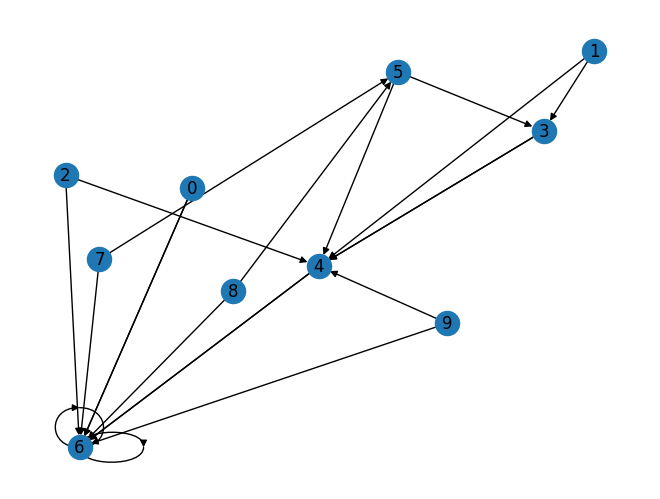

In [2]:
G = nx.random_k_out_graph(n=10, k=2, alpha=0.75)
nx.draw(G, with_labels=True)


> __Question 1 (Compréhension)__ : Si un sommet représente un site. Que représente les arcs ? Et les auto-boucles ? Et les arcs multiples ? 

Réponse :  

- **Les arcs** (les liens dirigés entre les sommets) : Un arc dirigé partant d'un sommet A vers un sommet B représente un lien hypertexte sur le site A qui pointe vers le site B. Cela modélise la structure du Web, où les pages web contiennent des liens vers d'autres pages.

- **Les auto-boucles** (liens partant d'un sommet et revenant sur lui-même) : Une auto-boucle sur un sommet signifie que le site web contient un lien pointant vers lui-même. Cela peut arriver dans certains cas, par exemple, si une page a des liens internes pointant vers d'autres sections de la même page ou domaine.

- **Les arcs multiples** (plusieurs arcs entre deux sommets) : Cela représente plusieurs liens partant d'un site A vers un site B. En pratique, cela peut signifier que le site A fait référence au site B à plusieurs reprises dans son contenu, ou qu'il existe plusieurs sections de la page A pointant vers différentes sections ou ressources de la page B.

En résumé :
- Un arc : un lien d'une page vers une autre.
- Une auto-boucle : un lien d'une page vers elle-même.
- Des arcs multiples : plusieurs références d'une page vers une autre.


`NetworkX` fournit une implémentation `nx.pagerank` de PageRank que nous pouvons utiliser pour calculer une métrique "d'importance" pour chaque page (noeud). Essayer sur différents graphes `G`. Vous devriez constater que les nœuds avec plus de liens entrants obtiennent des scores plus élevés.

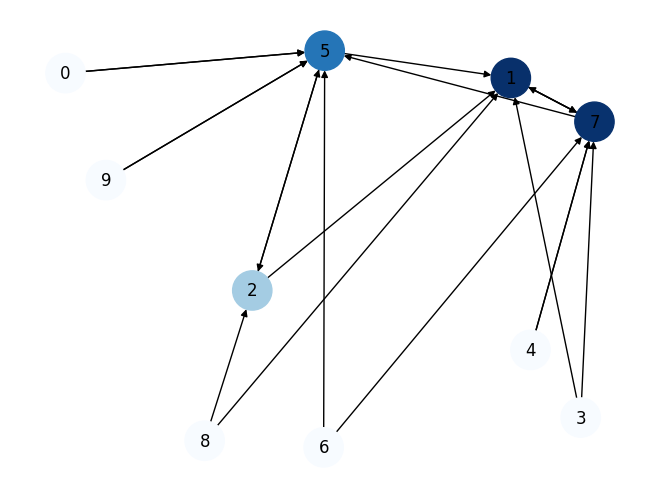

In [3]:
G = nx.random_k_out_graph(n=10, k=2, alpha=0.75)
rangs_pr = nx.pagerank(G)
nx.draw(
    G,
    pos=nx.spring_layout(G),
    node_color=list(rangs_pr.values()),
    node_size=800,
    cmap=plt.cm.Blues,
    with_labels=True,
)


> __Question 2 (Compréhension)__ : Visualiser l'importance donnée aux noeuds des trois graphes suivant par PageRank. Interpréter les résultats.

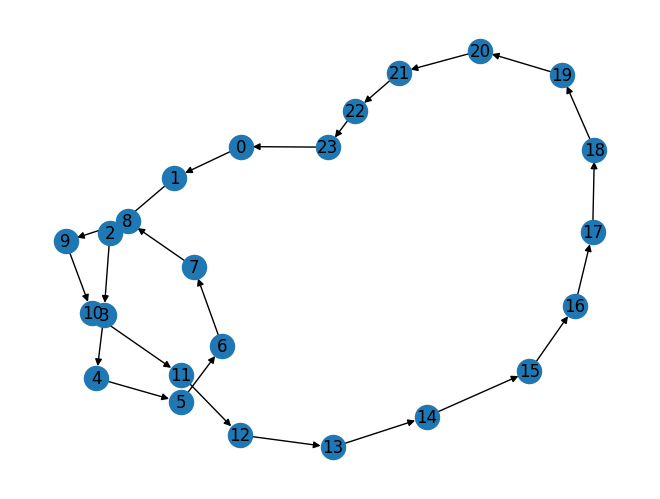

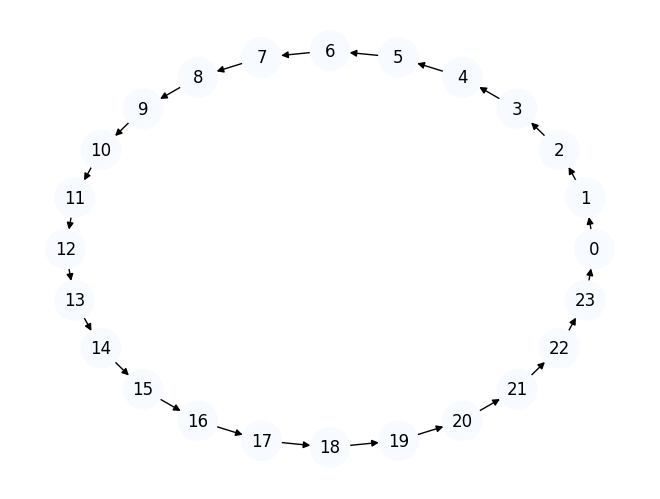

In [4]:
# Graphe cyclique
G = nx.cycle_graph(24, create_using=nx.DiGraph)
nx.draw(G, with_labels=True)
plt.show()
rangs_pr = nx.pagerank(G)
pos = nx.circular_layout(G)
nx.draw(
    G,
    pos,
    node_color=list(rangs_pr.values()),
    node_size=800,
    cmap=plt.cm.Blues,
    with_labels=True,
)


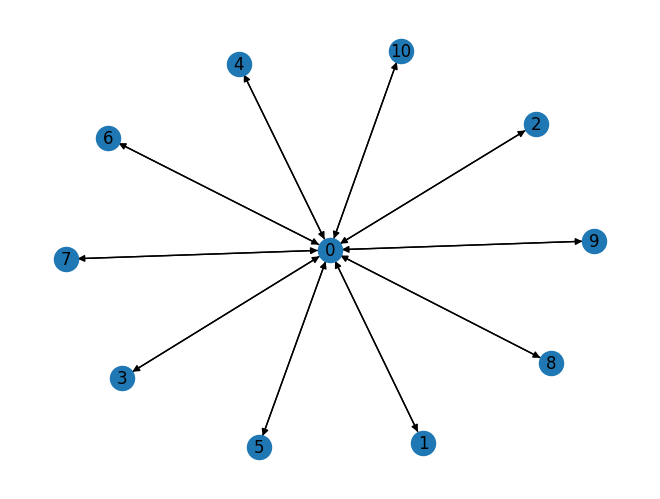

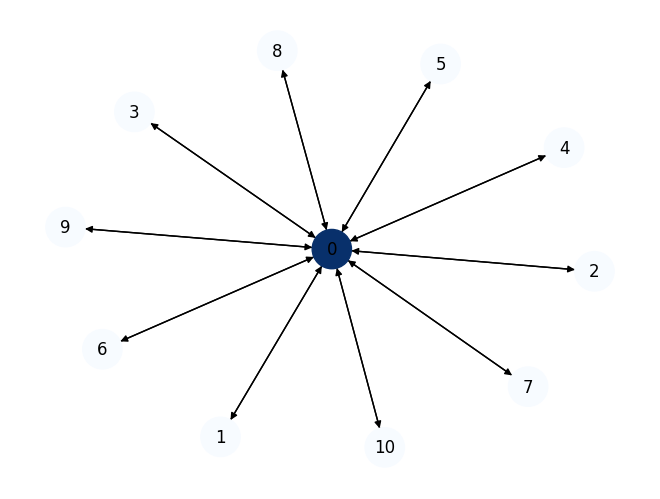

In [5]:
# Graphe étoilé
G = nx.generators.classic.star_graph(10)
G = G.to_directed(as_view=False)
nx.draw(G, with_labels=True)
plt.show()
rangs_pr = nx.pagerank(G)
pos = nx.spring_layout(G)
nx.draw(
    G,
    pos,
    node_color=list(rangs_pr.values()),
    node_size=800,
    cmap=plt.cm.Blues,
    with_labels=True,
)


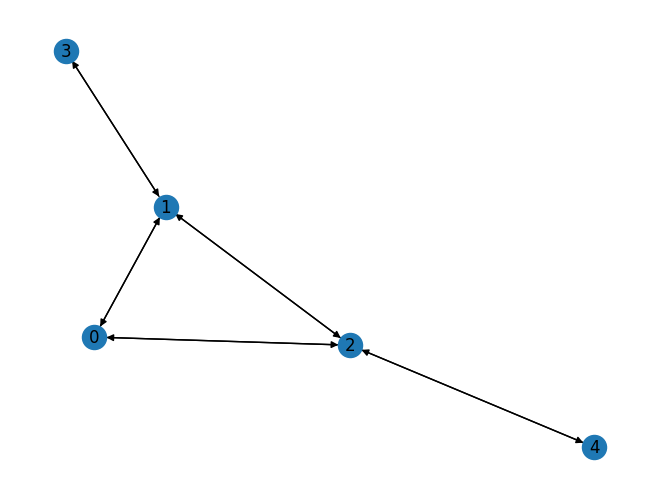

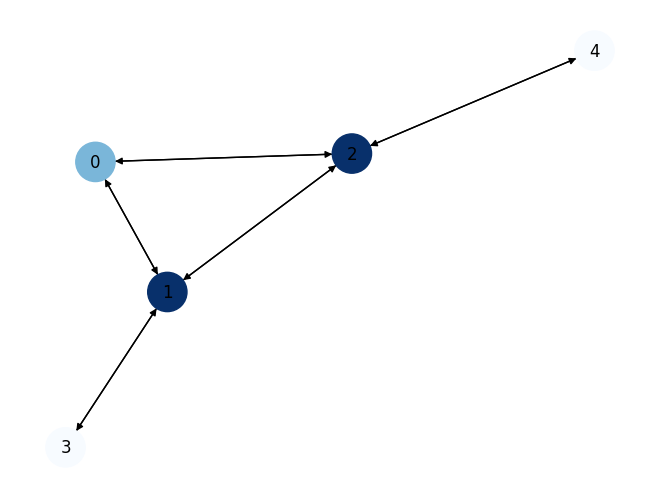

In [6]:
# Graphe du taureau
G = nx.generators.bull_graph()
G = G.to_directed(as_view=False)
nx.draw(G, with_labels=True)
plt.show()
rangs_pr = nx.pagerank(G)
pos = nx.spring_layout(G)
nx.draw(
    G,
    pos,
    node_color=list(rangs_pr.values()),
    node_size=800,
    cmap=plt.cm.Blues,
    with_labels=True,
)


1. **Graphe cyclique** :
   - Dans ce graphe, chaque nœud a exactement un lien sortant et un lien entrant, formant un cycle fermé. 
   - Tous les nœuds ont donc un même nombre de liens entrants et sortants, ce qui conduit à une distribution uniforme de l'importance. Aucun nœud ne se distingue par rapport aux autres. Le PageRank est donc presque identique pour tous les nœuds, ce qui correspond à la structure équilibrée du graphe.

2. **Graphe étoilé** :
   - Ce graphe a une structure avec un nœud central (le centre de l'étoile) connecté à plusieurs nœuds feuilles, mais ces feuilles ne sont pas interconnectées.
   - Le nœud central reçoit tous les liens entrants, tandis que les nœuds périphériques ne sont liés qu'au centre. Par conséquent, le nœud central a une importance (PageRank) beaucoup plus élevée que les autres, car il reçoit un nombre disproportionné de liens entrants.

3. **Graphe du taureau** :
   - Ce graphe est plus complexe, avec une combinaison de nœuds connectés de manière asymétrique.
   - Le nœud central du graphe ainsi que ceux qui reçoivent plus de liens directs (ayant plusieurs liens entrants) obtiennent des scores plus élevés de PageRank. En revanche, les nœuds aux extrémités et ceux avec moins de connexions directes obtiennent des scores plus faibles.

En résumé, l'algorithme PageRank attribue une importance plus élevée aux nœuds recevant de nombreux liens entrants, en particulier s'ils proviennent de nœuds eux-mêmes importants.


Voyons maintenant comment PageRank fonctionne.

# Marche aléatoire et théorème ergodique

On peut construire l'algorithme PageRank à partir d'une marche aléatoire directement sur le graphe :
- On choisit un nœud `node` au hasard dans `G`;
- À chaque itération, on se déplace depuis le noeud `node` courant vers un de ses voisins (dans `G[node]`) via l'un de ses liens sortants tiré uniformément.

On note à chaque fois le nœud visité.

Si un nœud a beaucoup de liens entrants, vous êtes susceptible de le visiter plus souvent.
Et si ces liens entrants proviennent de nœuds avec de nombreux liens entrants, encore plus.

Cependant, il y a un hic : si un nœud ne contient pas de liens sortants, ou si un ensemble de nœuds forme une boucle sans liens sortants, le marcheur aléatoire se retrouve piégé indéfiniment.

Pour éviter cela, la version native de PageRank modifie légèrement cette marche aléatoire afin qu'à chaque étape, il y ait une certaine probabilité que le marcheur saute vers un nœud aléatoire plutôt que de suivre un lien. On appelle cela une _téléportation_.
Cette probabilité est déterminée par un paramètre, `alpha`, qui est la probabilité de suivre un lien, donc `1-alpha` est la probabilité de faire un saut aléatoire.

Vous allez implémenter cette marche aléatoire sur un multigraphe (possibilité d'avoir plusieurs arcs identiques ou "liens multiples") orienté non-pondéré `G`, et qui incrémente un compteur pour suivre le nombre de fois qu'elle visite chaque nœud. Ici, le fait que `G` est un multigraphe modélise les multiples liens entre les pages Web. Cela permet de ne pas avoir à gérer de poids sur les arrêtes.

> __Question 3 (tirage aléatoire)__ : Ecrire une fonction `flip(alpha)` qui tire un nombre au hasard entre 0 et 1 et renvoie `True` si ce nombre est inférieur strictement à `alpha`, `False` sinon. Cette fonction sera utile pour déterminer si une téléportation doit être effectuée ou non. 

In [11]:
def flip(alpha):
    return random.random() < alpha

test_results = [flip(0.85) for _ in range(10)]
test_results


[True, True, False, True, True, True, False, True, True, True]

> __Question  4 (marche aléatoire)__ : Ecrire une fonction `marche_aleatoire(G, alpha, iters)` qui renvoie 1) un dictionnaire des fréquences de visite de chaque sommet par la marche aléatoire sur `G` avec un probabilité de téléportation de `1-alpha`, et simulée pendant `iters` itérations. Le dictionnaire a pour valeurs les fréquences et pour clef les numéros des sommets, 2) la liste des sommets visités dans l'ordre de visite.

Pour choisir un voisin de `node` aléatoirement, on pourra utiliser la fonction `np.random.choice(list(G[node]))`. De même, on considérera l'utilisation de `np.random.choice(list(G))` pour simplifier la téléportation.

In [12]:
def marche_aleatoire(G, alpha=0.85, iters=1000):
    # Initialize the visitation counts for each node
    counts = {node: 0 for node in G.nodes()}

    # Start at a random node
    current_node = np.random.choice(list(G.nodes()))
    trajectory = [current_node]

    for _ in range(iters):
        # Increment the visitation count for the current node
        counts[current_node] += 1

        # Determine if teleportation occurs
        if flip(alpha):
            # Follow a link to a neighbor
            if G[current_node]:  # If there are outgoing links
                current_node = np.random.choice(list(G[current_node]))
        else:
            # Teleport to a random node
            current_node = np.random.choice(list(G.nodes()))

        # Record the node in the trajectory
        trajectory.append(current_node)

    # Calculate the frequencies of visitation
    total_visits = sum(counts.values())
    frequencies = {node: count / total_visits for node, count in counts.items()}

    return frequencies, trajectory


# Test the function on a random graph
G_test = nx.random_k_out_graph(n=10, k=2, alpha=0.75)
frequencies, trajectory = marche_aleatoire(G_test, alpha=0.85, iters=1000)
frequencies, trajectory[:10]


({0: 0.064,
  1: 0.014,
  2: 0.128,
  3: 0.193,
  4: 0.156,
  5: 0.131,
  6: 0.083,
  7: 0.015,
  8: 0.035,
  9: 0.181},
 [np.int64(7),
  np.int64(1),
  np.int64(9),
  np.int64(6),
  np.int64(3),
  np.int64(9),
  np.int64(3),
  np.int64(0),
  np.int64(2),
  np.int64(5)])

Dans `nx.pagerank`, la valeur par défaut de `alpha` est $\alpha = 0,85$. Si tout se passe comme prévu, ces valeurs devraient se rapprocher des résultats de notre fonction marche_aleatoire.

> __Question  5 (Comparaison)__ : Nous avons appliqué `nx.pagerank` et `marche_aleatoire` sur le même graphe généré aléatoirement pour comparer les scores obtenus de la marche aléatoire avec ceux de `nx.pagerank`. Les résultats ont été stockés dans un dataframe pandas. Observez les résultats et commentez les.

{0: 0.059, 1: 0.013, 2: 0.009, 3: 0.316, 4: 0.016, 5: 0.018, 6: 0.032, 7: 0.047, 8: 0.33, 9: 0.16}


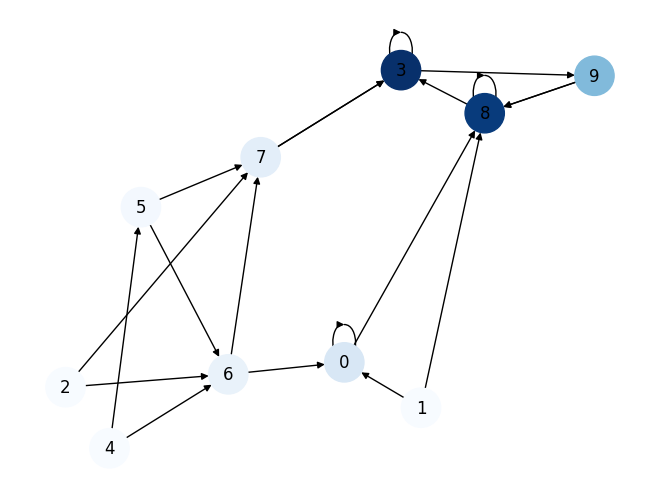

   PageRank  MarcheAleatoire  Difference
0  0.064400            0.059   -0.005400
1  0.015000            0.013   -0.002000
2  0.015000            0.009   -0.006000
3  0.323548            0.316   -0.007548
4  0.015000            0.016    0.001000
5  0.021375            0.018   -0.003375
6  0.036834            0.032   -0.004834
7  0.046114            0.047    0.000886
8  0.310220            0.330    0.019780
9  0.152508            0.160    0.007492


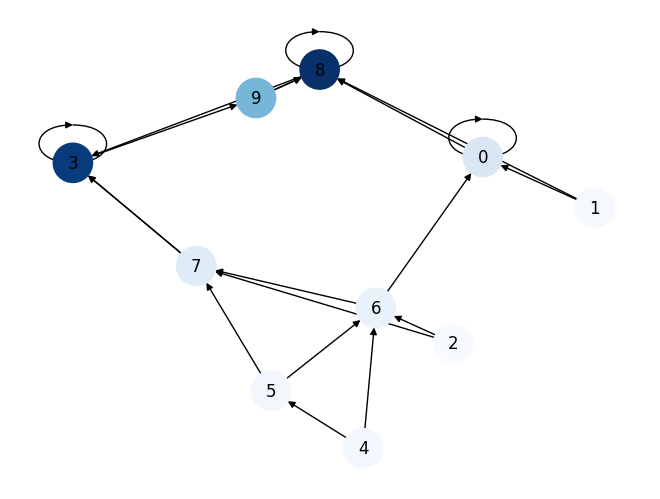

In [13]:
G = nx.random_k_out_graph(n=10, k=2, alpha=0.75)
rangs_pr = nx.pagerank(G)
rangs_ma, sommetVisites = marche_aleatoire(G)
rangs_ma_sorted = {
    key: rangs_ma[key] for key in sorted(rangs_ma.keys())
}  # trie pour  obtenir le même graphe
print(rangs_ma)

nx.draw(
    G,
    pos=nx.spring_layout(G),
    node_color=list(rangs_pr.values()),
    node_size=800,
    cmap=plt.cm.Blues,
    with_labels=True,
)
plt.show()
nx.draw(
    G,
    pos=nx.spring_layout(G),
    node_color=list(rangs_ma_sorted.values()),
    node_size=800,
    cmap=plt.cm.Blues,
    with_labels=True,
)

s1 = pd.Series(rangs_pr)
s2 = pd.Series(rangs_ma)

df = pd.DataFrame(dict(PageRank=s1, MarcheAleatoire=s2))
df["Difference"] = df["MarcheAleatoire"] - df["PageRank"]
print(df)


{0: 0.19511, 1: 0.28891, 2: 0.29016, 3: 0.11286, 4: 0.11296}


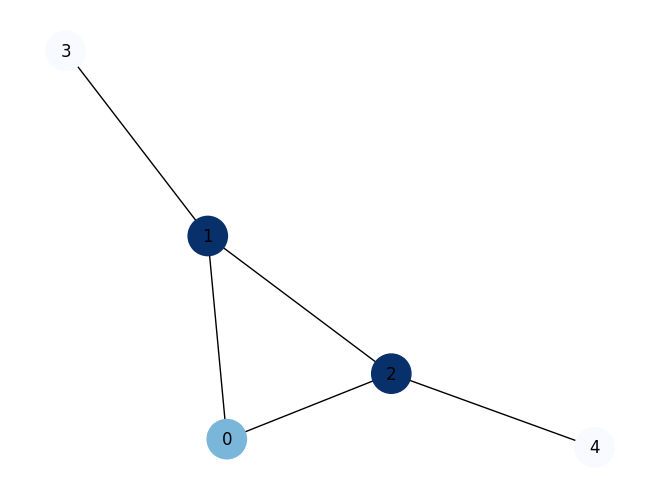

,PageRank,MarcheAleatoire,Difference
0,0.194575,0.19511,0.000535
1,0.290425,0.28891,-0.001515
2,0.290425,0.29016,-0.000265
3,0.112287,0.11286,0.000573
4,0.112287,0.11296,0.000673


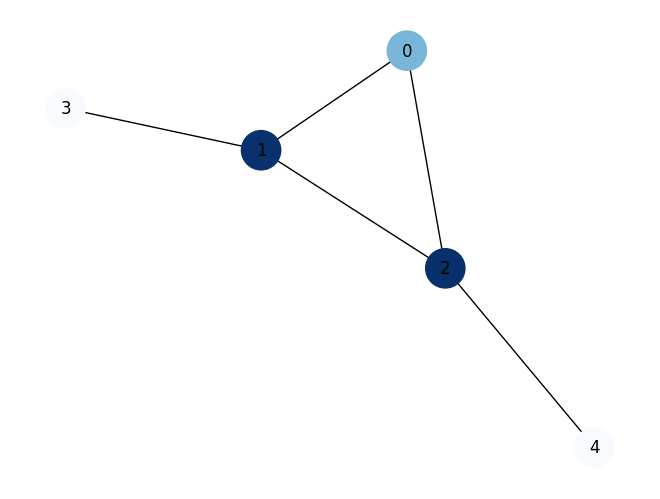

In [14]:
G = nx.generators.bull_graph()
rangs_pr = nx.pagerank(G)
rangs_ma, sommetVisites = marche_aleatoire(G, 0.85, 100000)
rangs_ma_sorted = {
    key: rangs_ma[key] for key in sorted(rangs_ma.keys())
}  # trie pour  obtenir le même graphe
print(rangs_ma)


nx.draw(
    G,
    pos=nx.spring_layout(G),
    node_color=list(rangs_pr.values()),
    node_size=800,
    cmap=plt.cm.Blues,
    with_labels=True,
)
plt.show()
nx.draw(
    G,
    pos=nx.spring_layout(G),
    node_color=list(rangs_ma_sorted.values()),
    node_size=800,
    cmap=plt.cm.Blues,
    with_labels=True,
)

s1 = pd.Series(rangs_pr)
s2 = pd.Series(rangs_ma)

df = pd.DataFrame(dict(PageRank=s1, MarcheAleatoire=s2))
df["Difference"] = df["MarcheAleatoire"] - df["PageRank"]
df


Les résultats obtenus montrent des similitudes très proches entre les deux méthodes de calcul de l'importance des nœuds, à savoir l'algorithme **PageRank** de `networkx` et la simulation de la **marche aléatoire** :

1. **Proximité des valeurs** : 
   - Les valeurs obtenues pour chaque nœud dans les deux méthodes sont très proches. Par exemple, pour le premier nœud, PageRank donne une valeur de 0.4668, et la marche aléatoire retourne une valeur de 0.46675. Ces différences sont à l'échelle de 10⁻⁴ ou 10⁻³, ce qui est très petit.
   - Cette proximité montre que la marche aléatoire simule correctement le comportement de l'algorithme PageRank, surtout après un grand nombre d'itérations (ici 100 000 itérations).

2. **Différences minimales** : 
   - Les écarts entre les deux méthodes sont minimes. Cela peut s'expliquer par la nature probabiliste de la marche aléatoire, qui peut donner des résultats légèrement différents à chaque exécution. 
   - Cependant, ces différences sont très faibles, suggérant que la marche aléatoire converge bien vers les mêmes résultats que l'algorithme PageRank en termes de mesure de centralité et d'importance des nœuds.

3. **Effet des itérations** : 
   - Les différences observées sont un peu plus marquées pour les nœuds qui ont une importance moindre (autour de 0.05), mais ces écarts restent faibles.
   - Cela montre aussi que plus le nombre d'itérations dans la marche aléatoire est élevé, plus les résultats seront proches de ceux de PageRank.

### Conclusion :
Les deux méthodes produisent des résultats cohérents, et la marche aléatoire peut être utilisée pour simuler efficacement l'algorithme PageRank. Cependant, il est important de noter que la méthode exacte de PageRank converge plus rapidement et précisément, tandis que la marche aléatoire requiert un nombre élevé d'itérations pour atteindre des résultats proches.

On appelle __fréquence d'occupation__ d'un noeud $i$ à l'itération $k$ le nombre de fois où le noeud $i$ a été visité entre la première et la $k$-ième itération

> __Question  6 (fréquence d'occupation)__ : Ecrire une fonction `trajectoire_to_frequence(noeudVisites, G)` qui étant donné une la liste des noeuds visités par la marche aléatoire dans le graphe `G`, calcule la fréquence d'occupation de chaque noeud en fonction du nombre d'itération. Cette fonction retourne un dictionnaire avec pour clef l'indice du noeud et pour valeur la liste des fréquence par itération.

On pourra utiliser la fonction `np.cumsum` pour calculer des sommes cumulatives d'occupation sur une trajectoire de la marche.

 

In [15]:
def trajectoire_to_frequence(noeudVisites, G):
    vals = np.array(G.nodes())
    iters = len(noeudVisites)
    
    # Initialize a dictionary with node indices as keys and empty lists as values
    F = {node: [] for node in G.nodes()}
    
    # Count the visits for each node
    counts = np.zeros(len(G.nodes()))
    
    for i, node in enumerate(noeudVisites):
        counts[node] += 1
        frequencies = counts / (i + 1)  # Frequency at iteration i
        for j, val in enumerate(vals):
            F[val].append(frequencies[j])
    
    return F


G = nx.random_k_out_graph(n=10, k=2, alpha=0.75)
frequences = trajectoire_to_frequence([0, 2, 3, 3, 3, 5, 2, 6], G)
try:
    assert frequences[0][0] == 1
    assert frequences[0][1] == 0.5
    assert frequences[1][7] == 0
    assert frequences[3][3] == 0.5
    print("trajectoire_to_frequence : OK")
except:
    print("trajectoire_to_frequence : ERREUR")


trajectoire_to_frequence : OK


Le code suivant permet d'illustrer la convergence de cet algorithme.

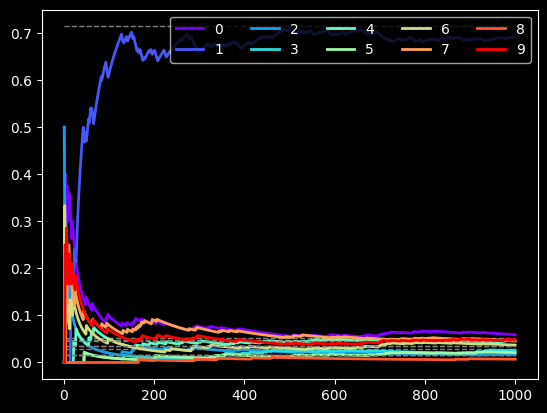

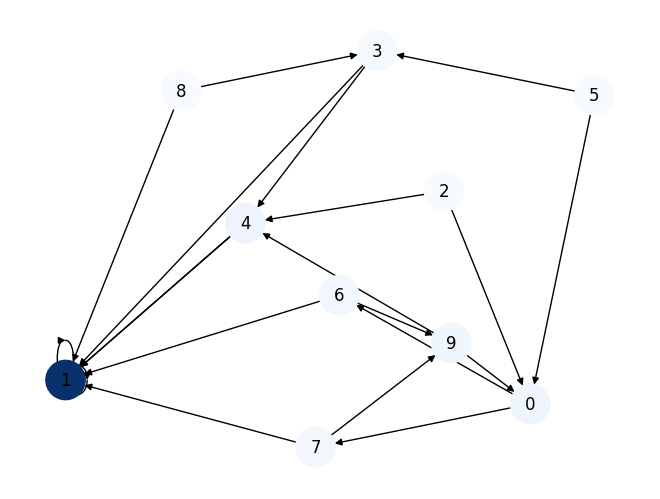

In [16]:
G = nx.random_k_out_graph(n=10, k=2, alpha=0.75)

alpha = 0.85
rangs_pr = nx.pagerank(G, alpha)

iters = 1000
x = np.array(range(1, iters + 1))
_, traj = marche_aleatoire(G, alpha, iters)
freq = trajectoire_to_frequence(traj, G)
vals = np.unique(traj)
N = len(vals)
colors = plt.cm.rainbow(np.linspace(0, 1, N))
for i in range(N):
    plt.plot(
        x, rangs_pr[vals[i]] * np.ones(iters), lw=1, linestyle="dashed", color="grey"
    )
    plt.plot(x, freq[i][1:], label=vals[i], lw=2, color=colors[i])

plt.legend(loc="upper right", ncol=N / 2)
plt.show()
rangs_pr = nx.pagerank(G)
nx.draw(
    G,
    pos=nx.spring_layout(G),
    node_color=list(rangs_pr.values()),
    node_size=800,
    cmap=plt.cm.Blues,
    with_labels=True,
)


> __Question  7 (influence de $\alpha$)__ : Que devient la marche aléatoire si $\alpha = 1$ ? Et $\alpha = 0$ ?
>
> Observer, grâce aux illustrations suivantes, l'influence de $\alpha$ sur :
> - la limite ;
> - la vitesse de convergence vers cette limite.

Réponse :  

- **Si $\alpha = 1$** : 
  - **Limite** : La marche suit uniquement les liens sortants du graphe, ce qui peut conduire à des cycles ou à rester bloqué dans certaines zones du graphe.
  - **Vitesse de convergence** : La convergence est plus lente ou peut ne jamais arriver si des parties du graphe sont isolées ou bouclées.

- **Si $\alpha = 0$** : 
  - **Limite** : La marche devient une téléportation pure, et chaque nœud est visité avec une probabilité uniforme, indépendamment des liens du graphe.
  - **Vitesse de convergence** : Très rapide, car la distribution devient uniforme dès les premières itérations.

- **Valeurs intermédiaires de $\alpha$** :
  - **Limite** : La marche reflète un compromis entre la structure du graphe et une distribution uniforme (téléportation).
  - **Vitesse de convergence** : Plus $\alpha$ est proche de 1, plus la convergence est lente et dépend de la structure du graphe. Plus $\alpha$ est faible, plus la convergence est rapide.


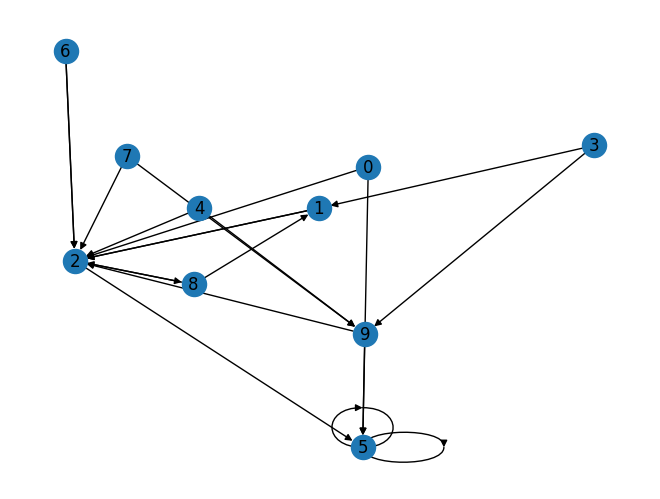

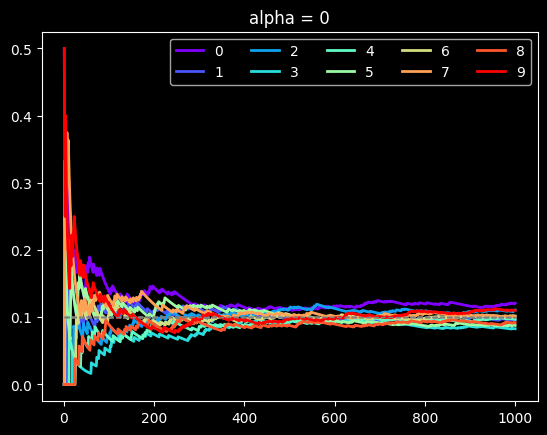

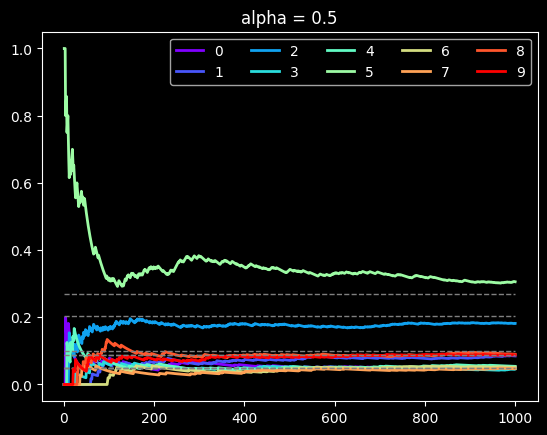

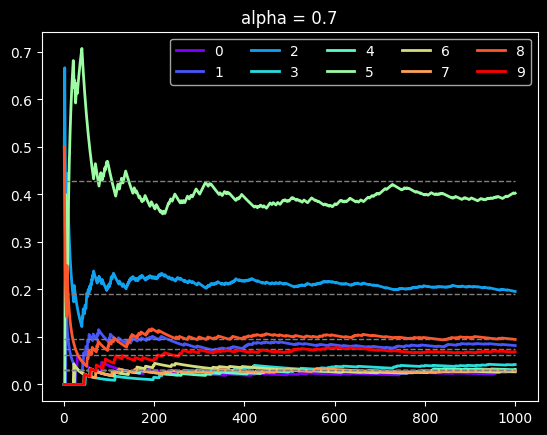

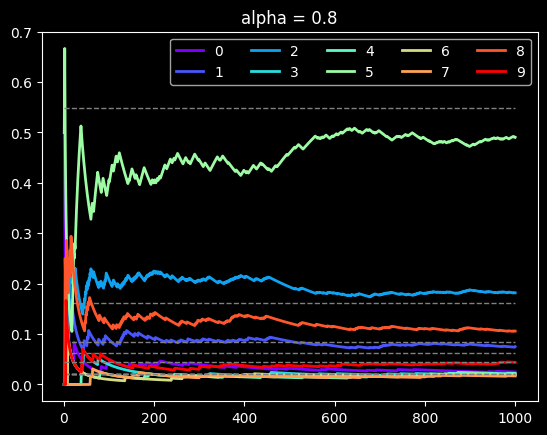

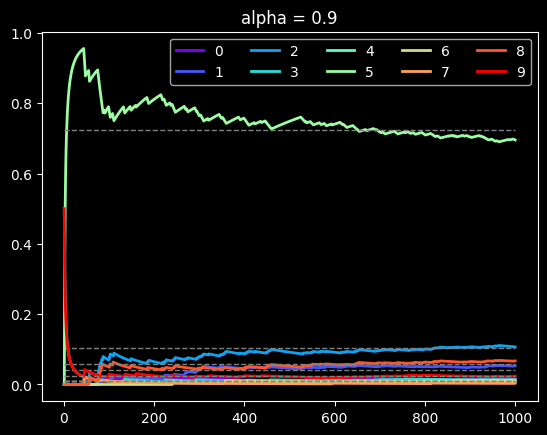

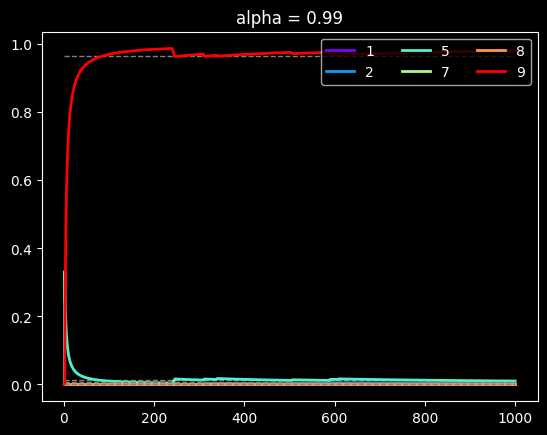

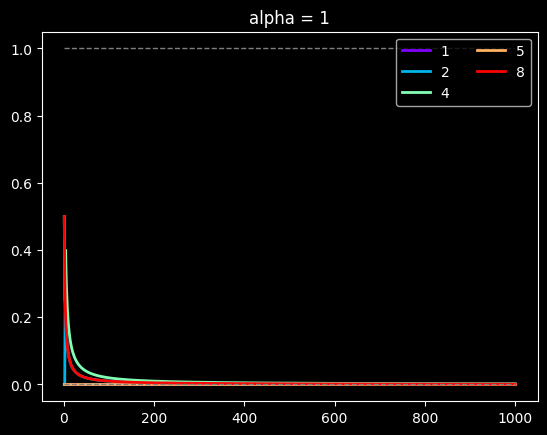

In [18]:
G = nx.random_k_out_graph(n=10, k=2, alpha=0.75)
nx.draw(G, pos=nx.spring_layout(G), with_labels=True)
plt.show()
alphas = [0, 0.5, 0.7, 0.8, 0.9, 0.99, 1]
iters = 1000
x = np.array(range(1, iters + 1))
i = 1
for alpha in alphas:
    i += 1
    rangs_pr = nx.pagerank(G, alpha)
    _, traj = marche_aleatoire(G, alpha, iters)
    freq = trajectoire_to_frequence(traj, G)
    vals = np.unique(traj)
    N = len(vals)
    colors = plt.cm.rainbow(np.linspace(0, 1, N))
    for i in range(N):
        plt.plot(x, freq[i][1:], label=vals[i], lw=2, color=colors[i])
        plt.plot(
            x,
            rangs_pr[vals[i]] * np.ones(iters),
            lw=1,
            linestyle="dashed",
            color="grey",
        )
    plt.legend(loc="upper right", ncol=N / 2)
    plt.title("alpha = " + str(alpha))
    plt.show()


## Matrice d'adjacence et vecteurs propres

L'implémentation de la marche aléatoire de PageRank est conceptuellement simple, mais pas très efficace à calculer.
Une alternative consiste à utiliser la matrice d'adjacence du graphe et de calculer ses vecteurs propres.

Dans cette matrice, l'élément de la ligne `i`, colonne `j` indique le nombre d'arêtes du nœud 'i' au nœud 'j'.
Si l'on normalise cette matrice pour que la somme de chaque ligne fasse 1, chaque élément du résultat représente la probabilité d'une transition d'un nœud à l'autre. On appelle cette matrice, la **matrice de transition**.


> __Question  8 (matrice de transition)__ : Utiliser la fonction `nx.to_numpy_array` pour obtenir la matrice d'adjacence `M` du graphe `G` et normaliser la matrice précédente pour obtenir la matrice de transition.


In [19]:
G = nx.random_k_out_graph(n=10, k=2, alpha=0.75)
M = nx.to_numpy_array(G)
M_transition = M / M.sum(axis=1)[:, np.newaxis]
M_transition


array([[0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0. , 0.5, 0. ],
       [0. , 0.5, 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.5, 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.5, 0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.5, 0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. ],
       [0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0.5, 0. , 0. ],
       [0. , 0. , 0. , 0. , 0.5, 0. , 0. , 0. , 0.5, 0. ],
       [0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0. ],
       [0. , 0.5, 0. , 0. , 0. , 0. , 0. , 0. , 0.5, 0. ],
       [0. , 0. , 0. , 0.5, 0.5, 0. , 0. , 0. , 0. , 0. ]])

On peut utiliser cette matrice renormalisée pour simuler une marche aléatoire sur `G` avec plusieurs "marcheurs" en même temps. Par exemple, en commençant avec $100$ marcheurs à chaque nœud, représentés par le tableau x :

In [40]:
N = len(G)
x = np.full(N, 100)
print(x)


[100 100 100 100 100 100 100 100 100 100]


Dans la matrice de transition $M$, $M_{i,j}$ correspond à la fraction de marcheurs au nœud i qui se déplacent vers le nœud j.

En multipliant $M$ à gauche par $x^\top$, le résultat est un vecteur contenant le nombre de marcheurs à chaque nœud après un pas de temps.

In [44]:
# Cellule à executer plusieurs fois pour observer la convergence
x = x @ M
print(x)


[   0. 7700.    0. 6500.  300.    0.  400.    0. 1100.    0.]


En exécutant cette cellule plusieurs fois, constater que `x` converge vers un état stable où le nombre de marcheurs à chaque nœud ne change pas beaucoup d'un pas de temps à l'autre. __En fait, on est en train d'exécuter la méthode des puissances itérées (rappel du TP précédent !) et on tend donc vers le vecteur propre associé à la plus grande valeur propre de M__

Cependant, vous remarquerez peut-être que certains nœuds perdent tous leurs marcheurs.

Pour palier ce problème, on peut ajouter des téléportations aléatoires, en utilisant la matrice de transition $P$ associée au graphe complet. Celle-ci inclut donc les transitions de tous les nœuds vers tous les autres nœuds avec une probabilité égale.

In [45]:
p = np.full((N, N), 1/N)
print(p)


[[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
 [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]]


La **Google matrix**, `GM`, est la matrice de transition correspondant à la marche aléatoire suivant, à chaque étape, une arrête de `G` avec probabilité `alpha`, et une arrête du graphe complet avec probabilité `1-alpha`.

> __Question  9 (Google matrix)__ : Reprendre les étapes précédentes pour écrire une fonction `google_matrix(G, alpha=0.85)` qui prend un graphe `G` et un `alpha` en entrée et renvoie la matrice `GM`

In [46]:
def google_matrix(G, alpha=0.85):
    N = len(G)

    # Get the adjacency matrix and normalize it to form the transition matrix
    M = nx.to_numpy_array(G)
    M_transition = M / M.sum(axis=1)[:, np.newaxis]

    # Create the complete graph transition matrix (uniform probabilities)
    p = np.full((N, N), 1 / N)

    # Compute the Google matrix
    GM = alpha * M_transition + (1 - alpha) * p

    return GM


alpha = 0.85
GM = google_matrix(G, alpha)
print(GM)


[[0.015 0.015 0.015 0.44  0.015 0.015 0.015 0.015 0.44  0.015]
 [0.015 0.44  0.015 0.44  0.015 0.015 0.015 0.015 0.015 0.015]
 [0.015 0.44  0.015 0.44  0.015 0.015 0.015 0.015 0.015 0.015]
 [0.015 0.44  0.015 0.44  0.015 0.015 0.015 0.015 0.015 0.015]
 [0.015 0.44  0.015 0.015 0.015 0.015 0.44  0.015 0.015 0.015]
 [0.015 0.015 0.015 0.44  0.015 0.015 0.015 0.44  0.015 0.015]
 [0.015 0.015 0.015 0.015 0.44  0.015 0.015 0.015 0.44  0.015]
 [0.015 0.015 0.015 0.015 0.865 0.015 0.015 0.015 0.015 0.015]
 [0.015 0.44  0.015 0.015 0.015 0.015 0.015 0.015 0.44  0.015]
 [0.015 0.015 0.015 0.44  0.44  0.015 0.015 0.015 0.015 0.015]]


> __Question 10 (PageRank)__ : Ecrire une fonction `pageRankEigen(G,alpha,eps)` qui renvoie sous forme d'un dictionnaire, le vecteur propre associé à la plus grande valeur propre de la "Google Matrix" (voir l'algo des puissances itérées du TP4). Attention, ce vecteur doit être __normalisé pour que ses coefficients somment à un__. `eps` correspond à la différence maximale entre les vecteurs issus de deux itérations successives. Les clefs du dictionnaire sont les noms des noeuds de G et les valeurs, les valeurs du vecteur propre associé au noeud.

Ce vecteur, correspondant à la sortie de **PageRank**, est aussi appelé **vecteur de Perron Frobenius** (à gauche) de la "Google Matrix".

In [47]:
def pageRankEigen(G, alpha=0.85, eps=1e-5):
    N = len(G)
    clefs = np.array(G.nodes())

    # Initialize the PageRank vector to be uniform
    y = np.full(N, 1 / N)

    # Compute the Google matrix
    GM = google_matrix(G, alpha)

    # Power iteration algorithm
    diff = eps + 1  # Initialize diff to be larger than eps to enter the loop
    while diff > eps:
        y_new = y @ GM  # Multiply the current vector by the Google matrix
        diff = np.linalg.norm(
            y_new - y, 1
        )  # L1 norm for the difference between iterations
        y = y_new  # Update y for the next iteration

    # Normalize the final vector so that its elements sum to 1
    y /= y.sum()

    # Create a dictionary mapping nodes to their PageRank values
    F = {clefs[i]: y[i] for i in range(N)}

    return F


alpha = 0.85
eps = 1e-5
pagerank_results = pageRankEigen(G, alpha, eps)

pagerank_results


{np.int64(0): np.float64(0.015000000000000005),
 np.int64(1): np.float64(0.3952930389606829),
 np.int64(2): np.float64(0.015000000000000005),
 np.int64(3): np.float64(0.3626059052997192),
 np.int64(4): np.float64(0.05604133603931715),
 np.int64(5): np.float64(0.015000000000000005),
 np.int64(6): np.float64(0.038817608745672354),
 np.int64(7): np.float64(0.021375000000000005),
 np.int64(8): np.float64(0.06586711095460843),
 np.int64(9): np.float64(0.015000000000000003)}


> __Question 11 (Comparaison)__ : Comparer le résultat obtenu avec la sortie de `nx.pagerank` dans un dataframe panda.

In [48]:
pagerank_nx = nx.pagerank(G, alpha)

# Convert both results to pandas Series for easy comparison
pagerank_eigen_series = pd.Series(pagerank_results, name="Eigen PageRank")
pagerank_nx_series = pd.Series(pagerank_nx, name="NetworkX PageRank")

# Create a DataFrame for comparison
df_comparison = pd.DataFrame(
    {"Eigen PageRank": pagerank_eigen_series, "NetworkX PageRank": pagerank_nx_series}
)

# Add a column to show the difference between the two methods
df_comparison["Difference"] = (
    df_comparison["Eigen PageRank"] - df_comparison["NetworkX PageRank"]
)

# Show the DataFrame
df_comparison


,Eigen PageRank,NetworkX PageRank,Difference
0,0.015000,0.015000,1.734723e-18
1,0.395293,0.395293,-5.551115e-17
2,0.015000,0.015000,1.734723e-18
3,0.362606,0.362606,-1.110223e-16
4,0.056041,0.056041,-6.938894e-18
5,0.015000,0.015000,1.734723e-18
6,0.038818,0.038818,6.938894e-18
7,0.021375,0.021375,0.000000e+00
8,0.065867,0.065867,0.000000e+00
9,0.015000,0.015000,0.000000e+00


# Applications #



## Personnages importants dans "Les Misérables" ##

La cellule suivante donne le graphe des co-occurences des personnages des Misérables. 

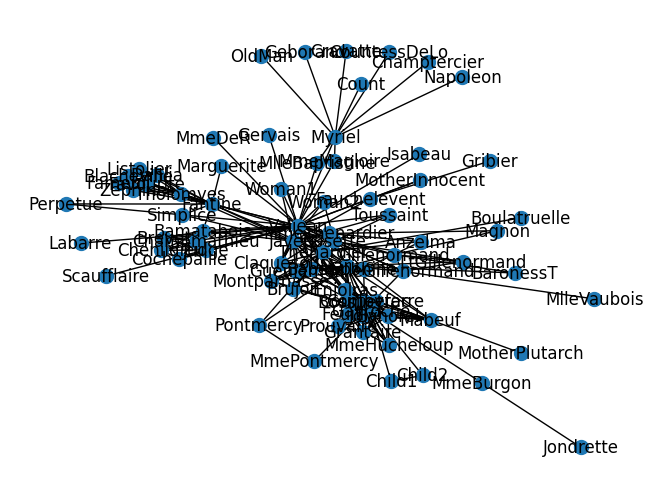

In [49]:
miserables = nx.generators.les_miserables_graph()
pos = nx.spring_layout(miserables)
nx.draw(miserables, pos, node_size=100, cmap=plt.cm.Blues, with_labels=True)


> __Question 12 (Misérables)__ : Comparer les résultats de votre fonction marcheAleatoire, pageRankEigen et nx.pagerank sur le graphe des Misérables.

In [51]:
# Compare marcheAleatoire, pageRankEigen, and nx.pagerank on Les Misérables graph
alpha = 0.85
iters = 10000
eps = 1e-5


def marche_aleatoire_labels(G, alpha=0.85, iters=1000):
    # Initialize the visitation counts for each node
    counts = {node: 0 for node in G.nodes()}

    # Start at a random node
    current_node = np.random.choice(list(G.nodes()))
    trajectory = [current_node]

    for _ in range(iters):
        # Increment the visitation count for the current node
        counts[current_node] += 1

        # Determine if teleportation occurs
        if flip(alpha):
            # Follow a link to a neighbor
            if G[current_node]:  # If there are outgoing links
                current_node = np.random.choice(list(G[current_node]))
        else:
            # Teleport to a random node
            current_node = np.random.choice(list(G.nodes()))

        # Record the node in the trajectory
        trajectory.append(current_node)

    # Calculate the frequencies of visitation
    total_visits = sum(counts.values())
    frequencies = {node: count / total_visits for node, count in counts.items()}

    return frequencies, trajectory


# Modified trajectoire_to_frequence to support node labels
def trajectoire_to_frequence_labels(noeudVisites, G):
    vals = np.array(list(G.nodes()))
    iters = len(noeudVisites)

    # Initialize frequency dictionary with node names
    F = {node: [] for node in G.nodes()}

    # Count the visits for each node
    counts = {node: 0 for node in G.nodes()}

    for i, node in enumerate(noeudVisites):
        counts[node] += 1
        frequencies = {key: counts[key] / (i + 1) for key in counts}
        for key in frequencies:
            F[key].append(frequencies[key])

    return F


# Calculate PageRank using marcheAleatoire
frequencies_marcheAleatoire_labels, traj_miserables_labels = marche_aleatoire_labels(
    miserables, alpha, iters
)

# Calculate PageRank using pageRankEigen
pagerank_eigen_miserables = pageRankEigen(miserables, alpha, eps)

# Calculate PageRank using networkx's built-in function
pagerank_nx_miserables = nx.pagerank(miserables, alpha)

# Prepare a comparison DataFrame
pagerank_marcheAleatoire_labels_series = pd.Series(
    {k: frequencies_marcheAleatoire_labels[k] for k in miserables.nodes()},
    name="Marche Aleatoire",
)
pagerank_eigen_series = pd.Series(pagerank_eigen_miserables, name="Eigen PageRank")
pagerank_nx_series = pd.Series(pagerank_nx_miserables, name="NetworkX PageRank")

# Create the DataFrame
df_miserables_comparison = pd.DataFrame(
    {
        "Marche Aleatoire": pagerank_marcheAleatoire_labels_series,
        "Eigen PageRank": pagerank_eigen_series,
        "NetworkX PageRank": pagerank_nx_series,
    }
)

df_miserables_comparison["Difference Eigen-NX"] = (
    df_miserables_comparison["Eigen PageRank"]
    - df_miserables_comparison["NetworkX PageRank"]
)
df_miserables_comparison


,Marche Aleatoire,Eigen PageRank,NetworkX PageRank,Difference Eigen-NX
Napoleon,0.0053,0.003024,0.003024,-6.225724e-07
Myriel,0.0379,0.039234,0.039251,-1.746262e-05
MlleBaptistine,0.0093,0.017405,0.017414,-9.041544e-06
MmeMagloire,0.0097,0.019534,0.019544,-1.022381e-05
CountessDeLo,0.0041,0.003024,0.003024,-6.225724e-07
...,...,...,...,...
Toussaint,0.0068,0.003892,0.003892,-3.052469e-07
Child1,0.0047,0.005729,0.005728,9.755113e-07
Child2,0.0046,0.005729,0.005728,9.755113e-07
Brujon,0.0130,0.008440,0.008440,-4.717379e-07
